In [1]:
import get_news
import pandas as pd

from pprint import pprint

In [2]:
new_path = './news_20191220.pkl'
#df = get_news.incrental_load('./news_20191220.pkl')

# Incrementally loading data
df = pd.read_pickle(new_path)

In [3]:
df.head()

,timestamp,headline,link,content
0,"Last updated March 07, 2020 10:57:09 AEDT",\n\t\t\t‘VIRUS MAN’ LEFT ON STREET: Disturbing...,https://www.news.com.au/world/north-america/ex...,Shocking footage of a man refused medical help...
1,"Last updated March 07, 2020 10:57:10 AEDT",\n\t\t\tFresh coronavirus case confirmed\n\t\t,https://www.news.com.au/national/australias-to...,Health authorities in Victoria have confirmed ...
2,"Last updated March 07, 2020 10:57:12 AEDT",\n\t\t\t21 cases of coronavirus confirmed on c...,https://www.news.com.au/travel/travel-updates/...,21 people have tested positive for COVID-19 af...
3,"Last updated March 07, 2020 10:57:12 AEDT",\n\t\t\tDisturbing Post Malone footage surface...,https://www.news.com.au/entertainment/music/he...,“He needs help”: Disturbing video footage of s...
4,"Last updated March 07, 2020 10:57:13 AEDT",\n\t\t\tMum ‘in tears’ over doctor surgery rul...,https://www.news.com.au/finance/business/other...,A Victorian woman was devastated after patient...


## Stem/Tokenise

Tokenise is basically a function converts sentses into "tokens" or a list of words. In function below we did **stem** on top of the tokenised words, and removed **stop words** from the tokens

In [4]:
import nltk
import re
from nltk.tokenize import punkt
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem import WordNetLemmatizer 
  
#sample = df.sample(1).content.iloc[0]
keep = re.compile('[a-zA-Z]')

ps = PorterStemmer()
lemmatizer = WordNetLemmatizer() 

def stem_tokenise(corpus):    
    return [lemmatizer.lemmatize(ps.stem(w.lower())) for w in word_tokenize(corpus) if re.match(keep, w)]

# stem tokenise the stop words as well
stop_words = stem_tokenise(" ".join(list(set(stopwords.words('english')))))

In [5]:
import spacy

def cleansing(text):    
    # Remove Emails
    text = re.sub(r'\S*@\S*\s?', '', text) 

    # Remove new line characters
    text = re.sub(r'\s+', ' ', text)

    # Remove distracting single quotes
    text = re.sub(r"\'", "", text)
    
    return text

# first of all remove the customerised clearning, then stem tokenise
data = df.content.map(cleansing).map(lambda x: " ". join(stem_tokenise(x)))


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en


# Do lemmatization keeping only Noun, Adj, Verb, Adverb
#data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
#print(data_lemmatized[:2])



In [6]:
nlp = spacy.load('en', disable=['parser', 'ner'])
doc = nlp("this is a test of beautiful day")
for token in doc:
    print(token.lemma_, token.pos_)

this DET
be AUX
a DET
test NOUN
of ADP
beautiful ADJ
day NOUN


## SKlearn DTM

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

Below is an example of sklearn LDA, the problem is it is pretty slow and not as customisable compared to gensim.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# use own tokeniser and stopwords (note: do the same processing for stop words)
#cv = CountVectorizer(stop_words=stop_words, tokenizer=stem_tokenise)

cv = CountVectorizer(analyzer='word',       
         min_df=10,                        # minimum reqd occurences of a word 
         stop_words='english',             # remove stop words
         lowercase=True,                   # convert all words to lowercase
         token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
         # max_features=50000,             # max number of uniq words
)


# get the dtm (coverting the matrix into dataframe)
data_cv = cv.fit_transform(data)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = df.index
#pprint(data_dtm)

# calculate the sparsity
data_dense = data_cv.todense()
# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  26.088617265087855 %


In [8]:
import numpy as np
data_dtm.iloc[1]
#pprint(row.nlargest(10))
#pprint(data.iloc[300])

abl        0
accept     0
accord     0
account    0
act        0
          ..
world      1
wrong      0
wrote      0
year       0
young      0
Name: 1, Length: 442, dtype: int64

## SKlearn Latent Direchlet Allocation

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

In [9]:
# simple LDA
lda = LatentDirichletAllocation(n_components=10, max_iter = 10, learning_method = 'online', batch_size = 128, random_state=0)
lda_output = lda.fit_transform(data_cv)

In [10]:
print("log likelihood: ", lda.score(data_cv))
print("Perplexity: ", lda.perplexity(data_cv))
pprint(lda.get_params())

log likelihood:  -99445.08057024257
Perplexity:  381.6379968358934
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 0,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


### Perform a grid search

In [11]:
from sklearn.model_selection import GridSearchCV

search_params = {'n_components': [10, 20, 30], 'learning_decay': [0.5, 0.7, 0.9]}
lda = LatentDirichletAllocation()
model = GridSearchCV(lda, param_grid=search_params)
model.fit(data_cv)

#best model
best_model = model.best_estimator_

In [12]:
print("best model parameters: ", best_model.get_params())
result = pd.DataFrame(model.cv_results_)
result

best model parameters:  {'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 10, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': None, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_decay,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.301682,0.014433,0.010648,0.001070,0.5,10,"{'learning_decay': 0.5, 'n_components': 10}",-28344.483208,-26120.364945,-28160.061570,-23252.607694,-16387.789686,-24453.061420,4430.679676,2
1,0.336130,0.024777,0.012679,0.002855,0.5,20,"{'learning_decay': 0.5, 'n_components': 20}",-30537.579544,-29487.169797,-31139.547200,-25389.758590,-19199.818952,-27150.774817,4453.276776,5
2,0.325580,0.021879,0.014116,0.001730,0.5,30,"{'learning_decay': 0.5, 'n_components': 30}",-33562.184191,-30528.495420,-32523.170696,-28185.823443,-20023.336034,-28964.601957,4833.211539,8
3,0.297720,0.016039,0.010327,0.000621,0.7,10,"{'learning_decay': 0.7, 'n_components': 10}",-28481.848189,-25861.283446,-27658.627378,-23282.611961,-16305.605029,-24317.995201,4385.194371,1
4,0.297324,0.014579,0.012257,0.001048,0.7,20,"{'learning_decay': 0.7, 'n_components': 20}",-31099.794420,-28850.153961,-30990.399554,-25837.407886,-19796.052939,-27314.761752,4216.818029,6
5,0.338434,0.025213,0.013447,0.002024,0.7,30,"{'learning_decay': 0.7, 'n_components': 30}",-33657.031097,-30228.865385,-30765.077626,-27707.206104,-22136.700413,-28898.976125,3873.982859,7
6,0.294678,0.016322,0.010234,0.001036,0.9,10,"{'learning_decay': 0.9, 'n_components': 10}",-28615.030379,-26053.469397,-27989.632378,-23593.993532,-16209.878864,-24492.400910,4496.019212,3
7,0.300784,0.010195,0.012444,0.001872,0.9,20,"{'learning_decay': 0.9, 'n_components': 20}",-31247.954497,-29194.562176,-30231.972948,-25938.191335,-18959.085027,-27114.353197,4450.286230,4
8,0.323775,0.011592,0.013450,0.001706,0.9,30,"{'learning_decay': 0.9, 'n_components': 30}",-33255.690541,-30146.230015,-33033.176196,-28394.902115,-22227.871544,-29411.574082,4026.714706,9


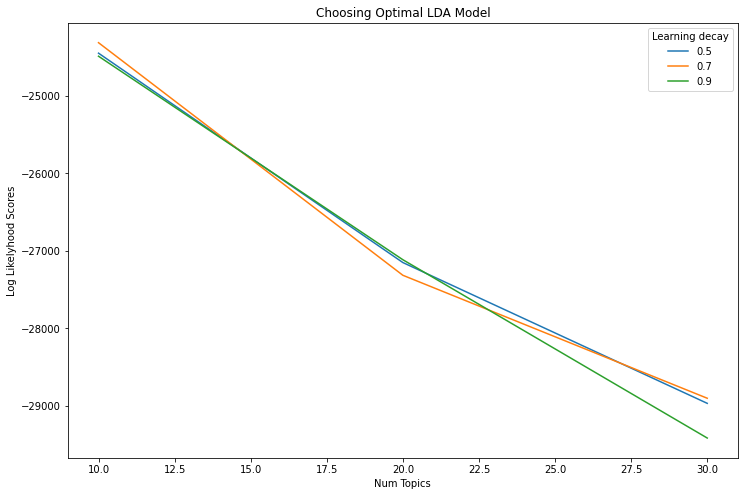

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 8))
for x in result.param_learning_decay.unique():
    plt.plot(result[result.param_learning_decay==x].param_n_components, result[result.param_learning_decay==x].mean_test_score, label=x)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

## Finding Dominate Topic

In [14]:
# Create Document - Topic Matrix
lda_output = best_model.transform(data_cv)

# column names
topicnames = ["Topic" + str(i) for i in range(best_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(20).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.470000,0.000000,0.030000,4
Doc1,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0.000000,0.000000,4
Doc2,0.000000,0.000000,0.060000,0.000000,0.940000,0.000000,0.000000,0.000000,0.000000,0.000000,4
Doc3,0.000000,0.000000,0.820000,0.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000,2
Doc4,0.000000,0.000000,0.520000,0.000000,0.070000,0.000000,0.050000,0.000000,0.100000,0.250000,2
Doc5,0.050000,0.000000,0.410000,0.110000,0.200000,0.130000,0.000000,0.100000,0.000000,0.000000,2
Doc6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,8
Doc7,0.000000,0.000000,0.370000,0.330000,0.000000,0.300000,0.000000,0.000000,0.000000,0.000000,2
Doc8,0.000000,0.000000,0.150000,0.160000,0.000000,0.530000,0.000000,0.000000,0.000000,0.150000,5
Doc9,0.000000,0.010000,0.460000,0.000000,0.000000,0.530000,0.000000,0.000000,0.000000,0.000000,5


## Review Topics Distribution

In [15]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,2,25
1,3,15
2,5,9
3,4,9
4,6,7
5,9,4
6,1,4
7,8,3
8,0,1


## Visualize the LDA model with pyLDAvis

In [16]:
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_model, data_cv, cv, mds='tsne')

pyLDAvis.display(panel)

In [1]:
import wordcloud as wc